# 主題模型 - LDA

套件設定

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams["font.sans-serif"] = ["SimHei"]

## 資料前處理

In [20]:
ptt = pd.read_csv("./rawData/noh_ptt.csv")  # 匯資料
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/TaiwanDrama/M.167841746...,[情報]《模仿犯 CopycatKiller》正式預告,2023-03-10 11:03:59,sodabubble,TaiwanDrama,《模仿犯 Copycat Killer》正式預告\nhttps://fb.com/Copyc...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""aax"", ""cmtCo...",61.224.18.162,2023-03-11 02:28:46,ptt
1,2,https://www.ptt.cc/bbs/TaiwanDrama/M.168007635...,[新聞]最帥檢察官！柯佳嬿甜讚「木村慷仁」吳慷仁陰影夢到兇手,2023-03-29 15:52:36,book8685,TaiwanDrama,最帥檢察官！柯佳嬿甜讚「木村慷仁」 吳慷仁陰影夢到兇手\nettoday 記者林奕如／台北報...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ysy2003"", ""c...",36.229.81.17,2023-03-30 02:16:02,ptt
2,3,https://www.ptt.cc/bbs/TaiwanDrama/M.168024673...,[情報]Netflix模仿犯10集上線了,2023-03-31 15:12:12,ashin0709,TaiwanDrama,Netflix台劇《模仿犯》將在2023年3月31上線！ 由吳慷仁、柯佳嬿、林心如、姚淳耀等...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Parsons25"", ...",42.74.158.222,2023-04-01 02:11:44,ptt


In [21]:
# 看看有幾篇文章
print(f"number of posts: {ptt.shape[0]}")
print(f"date range: {(ptt['artDate'].min(), ptt['artDate'].max())}")
print(f"category: \n{ptt['artCatagory'].value_counts()}")


number of posts: 98
date range: ('2023-03-10 11:03:59', '2023-05-20 13:51:04')
category: 
artCatagory
TaiwanDrama    98
Name: count, dtype: int64


In [22]:
# 移除網址格式
# 只留下中文字
ptt["artContent"] = ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ptt["artContent"] = ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/TaiwanDrama/M.167841746...,情報模仿犯正式預告,2023-03-10 11:03:59,sodabubble,TaiwanDrama,模仿犯正式預告正體中文影片上傳英語影片上傳日本語影片上傳週五獨家華語影集模仿犯改編自日本推理...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""aax"", ""cmtCo...",61.224.18.162,2023-03-11 02:28:46,ptt
1,2,https://www.ptt.cc/bbs/TaiwanDrama/M.168007635...,新聞最帥檢察官柯佳嬿甜讚木村慷仁吳慷仁陰影夢到兇手,2023-03-29 15:52:36,book8685,TaiwanDrama,最帥檢察官柯佳嬿甜讚木村慷仁吳慷仁陰影夢到兇手記者林奕如台北報導吳慷仁柯佳嬿在模仿犯曾是一對...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ysy2003"", ""c...",36.229.81.17,2023-03-30 02:16:02,ptt
2,3,https://www.ptt.cc/bbs/TaiwanDrama/M.168024673...,情報模仿犯集上線了,2023-03-31 15:12:12,ashin0709,TaiwanDrama,台劇模仿犯將在年月上線由吳慷仁柯佳嬿林心如姚淳耀等人主演劇情翻拍自日本宮部美幸同名小說以一個...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Parsons25"", ...",42.74.158.222,2023-04-01 02:11:44,ptt


### 從詞頻來檢視停用字清理狀況

In [24]:
ptt2 = ptt.copy()

In [25]:
word_df = ptt2.assign(word = ptt2['content'].apply(jieba.lcut)).explode('word').drop(['content'], axis=1)
word_df = word_df.loc[word_df['word'].str.len()>1]

KeyError: 'content'

#### 正式處理資料集

In [ ]:
# 留下 content
ptt["content"] = ptt["artTitle"] + ptt["artContent"]
ptt = ptt[["content", "artCatagory"]]
ptt.head()

In [16]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")


stopwords_manual = ['新聞','表示','行人','今年','指出','發生','相關','目前', '進行', '持續', '認為', '表現', '問題', '未來', 
                    '已經', '相關', '預期', '去年', '包括', '成為', '重要', '強調', '影響', '加強', '技術', '主要', '造成', '應用',
                    '增長', '億美元', '分局', '報導', '需求', '億元']
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords.extend(stopwords_manual)

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ptt["words"] = ptt["content"].apply(getToken)
ptt.head()

Building prefix dict from d:\Projects\NSYSU\SocialMediaProject\project II\dict\dict.txt.big ...
2023-06-07 20:26:30,371 : DEBUG : Building prefix dict from d:\Projects\NSYSU\SocialMediaProject\project II\dict\dict.txt.big ...
Dumping model to file cache C:\Users\s2568\AppData\Local\Temp\jieba.ud92a21fb1477a88e930439c2ae487cf8.cache
2023-06-07 20:26:31,780 : DEBUG : Dumping model to file cache C:\Users\s2568\AppData\Local\Temp\jieba.ud92a21fb1477a88e930439c2ae487cf8.cache
Loading model cost 1.537 seconds.
2023-06-07 20:26:31,910 : DEBUG : Loading model cost 1.537 seconds.
Prefix dict has been built successfully.
2023-06-07 20:26:31,912 : DEBUG : Prefix dict has been built successfully.


,content,artCatagory,words
0,情報模仿犯正式預告模仿犯正式預告正體中文影片上傳英語影片上傳日本語影片上傳週五獨家華語影集模...,TaiwanDrama,"[情報, 模仿, 正式, 預告, 模仿, 正式, 預告, 正體, 中文, 影片, 上傳, 英..."
1,新聞最帥檢察官柯佳嬿甜讚木村慷仁吳慷仁陰影夢到兇手最帥檢察官柯佳嬿甜讚木村慷仁吳慷仁陰影夢到...,TaiwanDrama,"[新聞, 最帥, 檢察官, 柯佳嬿甜, 木村, 慷仁, 吳慷仁, 陰影, 夢到, 兇手, 最..."
2,情報模仿犯集上線了台劇模仿犯將在年月上線由吳慷仁柯佳嬿林心如姚淳耀等人主演劇情翻拍自日本宮部...,TaiwanDrama,"[情報, 模仿, 犯集, 上線, 台劇, 模仿, 犯將, 上線, 由吳, 慷仁柯, 林心如,..."
3,新聞模仿犯從日本小說改編為台劇如何模仿犯從日本小說改編為台劇如何在類型裡找到與當代社會的連結...,TaiwanDrama,"[新聞, 模仿, 日本, 小說, 改編, 台劇, 模仿, 日本, 小說, 改編, 台劇, 類..."
4,模仿兇手是跟演員表現肯定有雷提醒閱讀完後請將以上提醒刪除我也不確定我快速秒快轉進有沒有看漏所...,TaiwanDrama,"[模仿, 兇手, 演員, 表現, 肯定, 有雷, 提醒, 閱讀, 完後請將, 提醒, 刪除,..."


## LDA 主題模型

In [9]:
docs = apple['words'].to_list()
docs[0]

['記者',
 '林丞偉',
 '台北',
 '報導',
 '世代',
 '女團',
 '由利善',
 '裴頡連穎',
 '巴倫',
 '席淇',
 '組成',
 '適逢',
 '出道',
 '前夕',
 '台北',
 '三創',
 '舉辦',
 '首場',
 '演唱會',
 '一口氣',
 '選秀',
 '出道',
 '首歌',
 '化身',
 '黑白',
 '舞力',
 '天使',
 '大秀辣',
 '美不勝收',
 '周湯豪',
 '閻奕',
 '格木',
 '木派',
 '崔克',
 '到場',
 '聆聽',
 '此次',
 '演唱會',
 '每位',
 '女孩',
 '提早',
 '半年前',
 '展開',
 '開唱',
 '訓練',
 '計畫',
 '包括',
 '體能訓練',
 '課程',
 '心肺',
 '有氧',
 '耐力',
 '整復',
 '身體',
 '放鬆',
 '透徹',
 '維持',
 '身體素質',
 '一周',
 '天排',
 '練唱',
 '訓練',
 '歌單',
 '每個',
 '開唱',
 '低碳斷',
 '每天',
 '以水',
 '食物',
 '大量',
 '蛋白質',
 '飲食',
 '控制',
 '成員',
 '短短',
 '公斤',
 '還換',
 '一身',
 '結實',
 '肌肉',
 '讓位',
 '成員',
 '女團',
 '變女',
 '漢子',
 '演唱會',
 '特別',
 '嘉賓',
 '請來',
 '原子',
 '少年',
 '學弟',
 '原名',
 '金星',
 '助陣',
 '兩團',
 '首次',
 '合作',
 '兩首歌',
 '標準',
 '舞還',
 '比美',
 '火花',
 '四射',
 '氣場',
 '超強',
 '台下',
 '放電',
 '粉絲',
 '電暈',
 '直呼',
 '美翻',
 '滿滿的',
 '舞力',
 '香味撲鼻',
 '魅力',
 '稱讚',
 '直呼',
 '女生',
 '漂亮',
 '還香站',
 '一起',
 '感覺',
 '比較',
 '感覺',
 '瞬間',
 '男團',
 '爆料',
 '網址',
 '爆料',
 '信箱',
 '下載',
 '壹蘋',
 '新聞網',
 '追蹤']

In [10]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-06-01 15:12:16,630 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-01 15:12:21,810 : INFO : built Dictionary<111565 unique tokens: ['一口氣', '一周', '一起', '一身', '三創']...> from 7981 documents (total 1506221 corpus positions)
2023-06-01 15:12:21,812 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<111565 unique tokens: ['一口氣', '一周', '一起', '一身', '三創']...> from 7981 documents (total 1506221 corpus positions)", 'datetime': '2023-06-01T15:12:21.812608', 'gensim': '4.3.1', 'python': '3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2023-06-01 15:12:22,005 : INFO : discarding 86822 tokens: [('以水', 2), ('低碳斷', 1), ('大秀辣', 1), ('天排', 1), ('巴倫', 1), ('席淇', 1), ('整復', 1), ('木派', 1), ('格木', 1), ('比美', 3)]...
2023-06-01 15:12:22,005 : INFO : keeping 24743 tokens which were in no less than 5 and no more than 7901 (=99.0%) documents
2023-06-01 15:12:22,114 : INFO : result

Dictionary<24743 unique tokens: ['一口氣', '一周', '一起', '一身', '三創']...>


In [11]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一口氣: 0
一周: 1
一起: 2
一身: 3
三創: 4
下載: 5
世代: 6
信箱: 7
兩團: 8
兩首歌: 9
公斤: 10
出道: 11


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>

In [12]:
pprint(" ".join(apple['words'].iloc[600]))


('記者 盈容 台北 報導 東森當 家主 吳宇 老公 朱凱翔 結婚 今年 周年 今日 吳宇 舒無 預警 宣布 懷孕 好消息 臉書 超音波 照及 微凸 小腹 '
 '承認 最近 太飽 三個 懷孕 五個 吳宇舒 過去 因未 懷孕 一直 關心 生小孩 問題 下蛋 網友 槓上 霸氣 酸民干 屁事 過去 受訪 表示 喜歡 '
 '小孩 排斥 真的 知道 這件 事情 一直 被問 公布 懷孕 消息 算是 打臉 一直 網友 吳宇 舒年 嫁給 交往 同台 政治 中心 組長 朱凱翔 婚後 '
 '男方 爆出 駕載 當時 記者 何庭歡 還與 同事 王乃 曖昧 朱凱翔 陸續 惹腥聞 過去 外界 替人 夫妻關係 打個 問號 多慮 爆料 網址 爆料 信箱 '
 '下載 壹蘋 新聞網 追蹤')


In [ ]:
dictionary.doc2bow(apple['words'].iloc[600])[:10]

In [13]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

# type(corpus)

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

**topic=5**

In [14]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=5, # 生成幾個主題數
    random_state=2023, # 亂數
)

2023-06-01 15:15:14,830 : INFO : using symmetric alpha at 0.2
2023-06-01 15:15:14,831 : INFO : using symmetric eta at 0.2
2023-06-01 15:15:14,835 : INFO : using serial LDA version on this node
2023-06-01 15:15:14,875 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-01 15:15:14,875 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-06-01 15:15:14,875 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-06-01 15:15:18,344 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-06-01 15:15:18,377 : INFO : topic #0 (0.200): 0.013*"爆料" + 0.007*"報導" + 0.006*"新聞網" + 0.006*"下載" + 0.006*"網址" + 0.006*"信箱" + 0.006*"壹蘋" + 0.006*"追蹤" + 0.005*"表示" + 0.004*"記者"
2023-06-01 15:15

## LDA 主題代表字

In [15]:
ldamodel.print_topics()

2023-06-01 15:15:49,003 : INFO : topic #0 (0.200): 0.020*"中國" + 0.013*"台灣" + 0.013*"爆料" + 0.007*"報導" + 0.007*"馬英九" + 0.007*"下載" + 0.006*"新聞網" + 0.006*"表示" + 0.006*"信箱" + 0.006*"壹蘋"
2023-06-01 15:15:49,003 : INFO : topic #1 (0.200): 0.010*"爆料" + 0.007*"報導" + 0.007*"下載" + 0.006*"壹蘋" + 0.006*"表示" + 0.006*"追蹤" + 0.006*"新聞網" + 0.005*"信箱" + 0.005*"網址" + 0.004*"發生"
2023-06-01 15:15:49,010 : INFO : topic #2 (0.200): 0.010*"表示" + 0.010*"台灣" + 0.009*"國民黨" + 0.009*"爆料" + 0.008*"總統" + 0.007*"中國" + 0.007*"美國" + 0.006*"報導" + 0.005*"網址" + 0.005*"追蹤"
2023-06-01 15:15:49,010 : INFO : topic #3 (0.200): 0.018*"立委" + 0.011*"爆料" + 0.009*"民進黨" + 0.007*"初選" + 0.007*"選區" + 0.007*"表示" + 0.007*"報導" + 0.006*"下載" + 0.005*"新聞網" + 0.005*"信箱"
2023-06-01 15:15:49,018 : INFO : topic #4 (0.200): 0.012*"爆料" + 0.008*"台灣" + 0.007*"表示" + 0.007*"追蹤" + 0.006*"新聞網" + 0.006*"壹蘋" + 0.006*"信箱" + 0.006*"下載" + 0.005*"報導" + 0.005*"網址"


[(0,
  '0.020*"中國" + 0.013*"台灣" + 0.013*"爆料" + 0.007*"報導" + 0.007*"馬英九" + 0.007*"下載" + 0.006*"新聞網" + 0.006*"表示" + 0.006*"信箱" + 0.006*"壹蘋"'),
 (1,
  '0.010*"爆料" + 0.007*"報導" + 0.007*"下載" + 0.006*"壹蘋" + 0.006*"表示" + 0.006*"追蹤" + 0.006*"新聞網" + 0.005*"信箱" + 0.005*"網址" + 0.004*"發生"'),
 (2,
  '0.010*"表示" + 0.010*"台灣" + 0.009*"國民黨" + 0.009*"爆料" + 0.008*"總統" + 0.007*"中國" + 0.007*"美國" + 0.006*"報導" + 0.005*"網址" + 0.005*"追蹤"'),
 (3,
  '0.018*"立委" + 0.011*"爆料" + 0.009*"民進黨" + 0.007*"初選" + 0.007*"選區" + 0.007*"表示" + 0.007*"報導" + 0.006*"下載" + 0.005*"新聞網" + 0.005*"信箱"'),
 (4,
  '0.012*"爆料" + 0.008*"台灣" + 0.007*"表示" + 0.007*"追蹤" + 0.006*"新聞網" + 0.006*"壹蘋" + 0.006*"信箱" + 0.006*"下載" + 0.005*"報導" + 0.005*"網址"')]

使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [16]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.63941115), (4, 0.355023)]

## LDA 模型指標

+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，`數字越大越好`。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此`數字要越小越好`。

In [17]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-06-01 15:17:54,953 : INFO : -8.690 per-word bound, 413.1 perplexity estimate based on a held-out corpus of 7981 documents with 1343192 words


-8.690328181697957

In [18]:
np.exp2(-perplexity)

413.09454004457734

In [19]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

2023-06-01 15:19:02,533 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2023-06-01 15:19:21,226 : INFO : 1 batches submitted to accumulate stats from 64 documents (10387 virtual)
2023-06-01 15:19:21,231 : INFO : 2 batches submitted to accumulate stats from 128 documents (22001 virtual)
2023-06-01 15:19:21,247 : INFO : 3 batches submitted to accumulate stats from 192 documents (32693 virtual)
2023-06-01 15:19:21,264 : INFO : 4 batches submitted to accumulate stats from 256 documents (44265 virtual)
2023-06-01 15:19:21,296 : INFO : 5 batches submitted to accumulate stats from 320 documents (55195 virtual)
2023-06-01 15:19:21,328 : INFO : 6 batches submitted to accumulate stats from 384 documents (66752 virtual)
2023-06-01 15:19:21,352 : INFO : 7 batches submitted to accumulate stats from 448 documents (77785 virtual)
2023-06-01 15:19:21,368 : INFO : 8 batches submitted to accumulate stats from 512 documents (8893

這個主題的 PMI score:  0.0368437043046269


In [20]:
PMI_model_lda.get_coherence_per_topic()

[0.03138506377240712,
 0.040146562291136105,
 0.0199536011165205,
 0.06556919169483014,
 0.02716410264824063]

`npmi` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

### **透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>


In [21]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-06-01 15:21:03,166 : INFO : using symmetric alpha at 0.5
2023-06-01 15:21:03,166 : INFO : using symmetric eta at 0.5
2023-06-01 15:21:03,177 : INFO : using serial LDA version on this node
2023-06-01 15:21:03,188 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-01 15:21:03,190 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-06-01 15:21:05,871 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-06-01 15:21:05,880 : INFO : topic #0 (0.500): 0.010*"爆料" + 0.007*"追蹤" + 0.006*"報導" + 0.006*"表示" + 0.006*"壹蘋" + 0.005*"網址" + 0.005*"下載" + 0.005*"信箱" + 0.005*"粉絲" + 0.005*"記者"
2023-06-01 15:21:05,881 : INFO : topic #1 (0.500): 0.012*"爆料" + 0.007*"新聞網" + 0.007*"報導" + 0.006*"下載" + 0.006*"信箱" + 0.006*"網址" + 0.006*"壹蘋" + 0.005*"記者" + 0.005*"追蹤" + 0.004*

花費時間: 884.1958277225494 sec


In [22]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5077.643181,0.032462
1,3,4793.173641,0.039046
2,4,4617.824236,0.037680
3,5,4588.488724,0.030429
4,6,4618.103569,0.033109
5,7,4582.025580,0.020680
6,8,4451.383938,0.038253
7,9,4523.556808,0.027040


<Axes: xlabel='topic_num'>

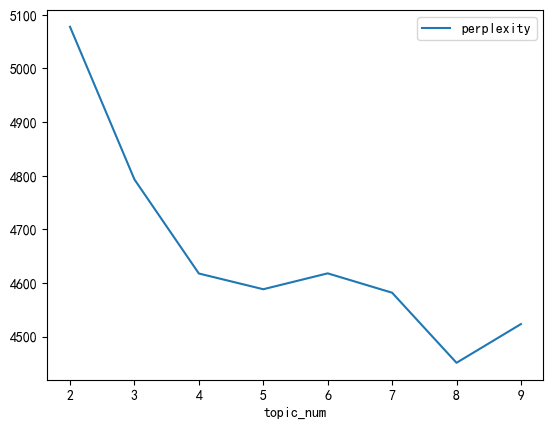

In [23]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

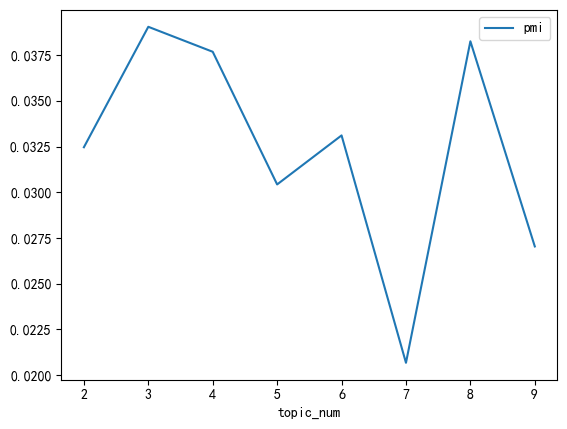

In [24]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 到3之後逐漸降低。<br>
而coherence 最高則是8。

## 視覺化呈現

In [25]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2023-06-01 15:43:21,862 : INFO : using symmetric alpha at 0.125
2023-06-01 15:43:21,864 : INFO : using symmetric eta at 0.125
2023-06-01 15:43:21,870 : INFO : using serial LDA version on this node
2023-06-01 15:43:21,917 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-01 15:43:21,917 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-06-01 15:43:25,816 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-06-01 15:43:25,846 : INFO : topic #2 (0.125): 0.008*"爆料" + 0.005*"表示" + 0.005*"報導" + 0.005*"新聞網" + 0.005*"記者" + 0.005*"信箱" + 0.005*"網址" + 0.005*"追蹤" + 0.005*"壹蘋" + 0.004*"下載"
2023-06-01 15:43:25,850 : INFO : topic #5 (0.125): 0.009*"爆料" + 0.006*"報導" + 0.006*"追蹤" + 0.006*"表示" + 0.005*"壹蘋" + 0.005*"信箱" + 0.005*"記者" + 0.005*"台北" + 0.004*"下載" + 0.

In [26]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.189664  0.107110       1        1  22.528852
1      0.085144 -0.116037       2        1  19.112902
2     -0.192638 -0.135882       3        1  14.302650
5     -0.136132  0.111060       4        1  12.798285
0      0.134057 -0.065672       5        1  11.196228
4      0.144128  0.176892       6        1   6.822780
3     -0.032467 -0.077157       7        1   6.717303
6      0.187573 -0.000313       8        1   6.521000, topic_info=      Term         Freq        Total Category  logprob  loglift
5102   國民黨  4532.000000  4532.000000  Default  30.0000  30.0000
385     中國  8389.000000  8389.000000  Default  29.0000  29.0000
14601  民進黨  2573.000000  2573.000000  Default  28.0000  28.0000
16144   立委  3106.000000  3106.000000  Default  27.0000  27.0000
11407   總統  4675.000000  4675.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
27      壹蘋   323.732082  7274.854036   Topic8  -5.6005  -0.3821
26      報導   303.074761  8882.336568   Topic8  -5.6664  -0.6477
168     日本   258.201408  2242.223269   Topic8  -5.8267   0.5687
352     表示   281.903523  9519.776350   Topic8  -5.7389  -0.7894
538     台灣   260.684708  8273.138153   Topic8  -5.8171  -0.7273

[663 rows x 6 columns], token_table=       Topic      Freq Term
term                       
796        1  0.174615   一名
796        2  0.043096   一名
796        3  0.001486   一名
796        4  0.369291   一名
796        5  0.390096   一名
...      ...       ...  ...
21733      3  0.985277   黨員
11415      1  0.016977   黨團
11415      3  0.977864   黨團
18474      2  0.012818   黨部
18474      3  0.986980   黨部

[1886 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 6, 1, 5, 4, 7])

In [27]:
pyLDAvis.save_html(p, "lda_zh.html")

## 用topic=8跑不同的訓練次數看看結果

In [29]:
t0 = time.time()

train_num_list = np.arange(5, 10)
result = {"train_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for train_num in train_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = 8 ,
        id2word=dictionary,
        random_state = 1500,
        passes=train_num # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{train_num}'] = model
    
    result['train_num'].append(train_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-06-01 15:51:13,448 : INFO : using symmetric alpha at 0.125
2023-06-01 15:51:13,449 : INFO : using symmetric eta at 0.125
2023-06-01 15:51:13,462 : INFO : using serial LDA version on this node
2023-06-01 15:51:13,503 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-01 15:51:13,505 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-06-01 15:51:17,712 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-06-01 15:51:17,732 : INFO : topic #2 (0.125): 0.008*"爆料" + 0.005*"表示" + 0.005*"報導" + 0.005*"新聞網" + 0.005*"記者" + 0.005*"信箱" + 0.005*"網址" + 0.005*"追蹤" + 0.005*"壹蘋" + 0.004*"下載"
2023-06-01 15:51:17,733 : INFO : topic #5 (0.125): 0.009*"爆料" + 0.006*"報導" + 0.006*"追蹤" + 0.006*"表示" + 0.005*"壹蘋" + 0.005*"信箱" + 0.005*"記者" + 0.005*"台北" + 0.004*"下載" + 0.

花費時間: 748.1575968265533 sec


In [30]:
result = pd.DataFrame(result)
result

,train_num,perplexity,pmi
0,5,4451.383938,0.038253
1,6,4395.167560,0.046474
2,7,4359.879698,0.047071
3,8,4335.820424,0.046186
4,9,4318.395721,0.046760


<Axes: xlabel='train_num'>

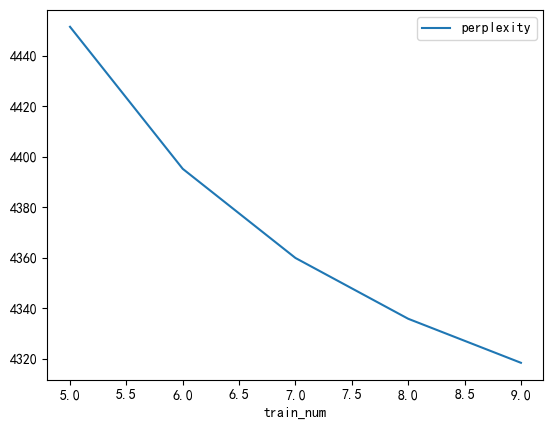

In [31]:
result.plot.line(x='train_num', y='perplexity')

<Axes: xlabel='train_num'>

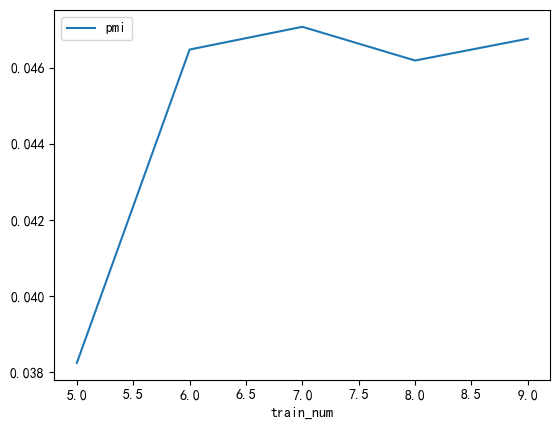

In [32]:
result.plot.line(x='train_num', y='pmi')

從圖表可知train的次數越多，得到的效果越好，因此再次做一次視覺化進行驗證

In [33]:
best_model2 = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 10 # 訓練次數
    )

2023-06-01 16:05:40,668 : INFO : using symmetric alpha at 0.125
2023-06-01 16:05:40,673 : INFO : using symmetric eta at 0.125
2023-06-01 16:05:40,685 : INFO : using serial LDA version on this node
2023-06-01 16:05:40,766 : INFO : running online (multi-pass) LDA training, 8 topics, 10 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-01 16:05:40,770 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-06-01 16:05:44,835 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-06-01 16:05:44,857 : INFO : topic #2 (0.125): 0.008*"爆料" + 0.005*"表示" + 0.005*"報導" + 0.005*"新聞網" + 0.005*"記者" + 0.005*"信箱" + 0.005*"網址" + 0.005*"追蹤" + 0.005*"壹蘋" + 0.004*"下載"
2023-06-01 16:05:44,858 : INFO : topic #5 (0.125): 0.009*"爆料" + 0.006*"報導" + 0.006*"追蹤" + 0.006*"表示" + 0.005*"壹蘋" + 0.005*"信箱" + 0.005*"記者" + 0.005*"台北" + 0.004*"下載" + 0

In [34]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model2, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.189529 -0.031301       1        1  21.874293
1     -0.072822  0.104802       2        1  19.309047
2      0.205000 -0.033269       3        1  14.391442
5      0.132592  0.165128       4        1  13.653269
0     -0.131403  0.150533       5        1  10.829891
3      0.037041 -0.208763       6        1   6.870476
6     -0.188760 -0.046542       7        1   6.669242
4     -0.171177 -0.100587       8        1   6.402340, topic_info=      Term         Freq        Total Category  logprob  loglift
5102   國民黨  3791.000000  3791.000000  Default  30.0000  30.0000
385     中國  8512.000000  8512.000000  Default  29.0000  29.0000
538     台灣  8220.000000  8220.000000  Default  28.0000  28.0000
16144   立委  2995.000000  2995.000000  Default  27.0000  27.0000
991     美國  5172.000000  5172.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
44     新聞網   443.995429  7338.276785   Topic8  -5.2662  -0.0565
870     女星   198.603319   558.520363   Topic8  -6.0707   1.7145
26      報導   425.370718  8768.432482   Topic8  -5.3091  -0.2774
2109    使用   203.366476   920.425665   Topic8  -6.0470   1.2387
101     今年   203.768086  1370.236861   Topic8  -6.0451   0.8428

[630 rows x 6 columns], token_table=       Topic      Freq Term
term                       
796        1  0.060607   一名
796        2  0.015742   一名
796        4  0.665892   一名
796        5  0.236132   一名
796        7  0.022039   一名
...      ...       ...  ...
11415      3  0.994398   黨團
17544      3  0.132873   黨派
17544      4  0.005777   黨派
17544      6  0.855011   黨派
18474      3  0.996500   黨部

[1565 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 6, 1, 4, 7, 5])

In [35]:
pyLDAvis.save_html(p, "lda_2.html")

部分topic重疊或主題字較沒意義<br>
因此降低topic_num

In [36]:
best_model3 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 10 # 訓練次數
    )

2023-06-01 16:09:56,080 : INFO : using symmetric alpha at 0.2
2023-06-01 16:09:56,083 : INFO : using symmetric eta at 0.2
2023-06-01 16:09:56,093 : INFO : using serial LDA version on this node
2023-06-01 16:09:56,122 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-01 16:09:56,127 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-06-01 16:10:00,971 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-06-01 16:10:00,984 : INFO : topic #0 (0.200): 0.012*"爆料" + 0.007*"報導" + 0.006*"粉絲" + 0.006*"追蹤" + 0.006*"壹蘋" + 0.006*"表示" + 0.005*"下載" + 0.005*"記者" + 0.005*"信箱" + 0.004*"新聞網"
2023-06-01 16:10:00,990 : INFO : topic #1 (0.200): 0.014*"爆料" + 0.007*"新聞網" + 0.007*"報導" + 0.007*"下載" + 0.006*"壹蘋" + 0.006*"信箱" + 0.006*"記者" + 0.005*"網址" + 0.005*"台北" + 0.00

In [37]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model3, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.157098  0.047796       1        1  31.830938
2      0.122361 -0.158401       2        1  30.486154
3      0.089134 -0.077470       3        1  15.514001
0     -0.190847 -0.024849       4        1  12.216360
4      0.136450  0.212924       5        1   9.952547, topic_info=      Term         Freq        Total Category  logprob  loglift
20847  烏克蘭  2140.000000  2140.000000  Default  30.0000  30.0000
11407   總統  4414.000000  4414.000000  Default  29.0000  29.0000
5102   國民黨  3410.000000  3410.000000  Default  28.0000  28.0000
528    俄羅斯  1770.000000  1770.000000  Default  27.0000  27.0000
16144   立委  3219.000000  3219.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
27      壹蘋   695.726742  7202.551680   Topic5  -5.2583  -0.0299
821     攻擊   325.961299   738.965823   Topic5  -6.0164   1.4889
352     表示   471.112875  9435.343965   Topic5  -5.6481  -0.6898
15      包括   337.213503  1657.055160   Topic5  -5.9825   0.7153
168     日本   328.647561  2245.362143   Topic5  -6.0082   0.3857

[421 rows x 6 columns], token_table=       Topic      Freq Term
term                       
796        1  0.009979   一名
796        2  0.012282   一名
796        3  0.175024   一名
796        4  0.784539   一名
796        5  0.017656   一名
...      ...       ...  ...
4657       4  0.935788   駕駛
4657       5  0.046432   駕駛
20327      2  0.998688  麥卡錫
8638       3  0.980418   黑鷹
21556      2  0.998793   黨內

[874 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

In [38]:
pyLDAvis.save_html(p, "lda_3.html")